In [2]:
import numpy as np
from sympy.parsing.sympy_parser import parse_expr
from sympy.utilities.lambdify import lambdify
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
# Нелинейная система
nonlinear_system = [parse_expr('x2'),
                    parse_expr('((1+x3)**2/(1-x1)**2 - 1)/2'),
                    parse_expr('-x2*(1+x3)/(1-x1) -5*(1-x1)*x3 + (1-x1)*u')] 
# Линейная система
linear_system = [parse_expr('x2'),
                 parse_expr('x1 + x3'),
                 parse_expr('-x2 - 5*x3 + u')]
# Переменные системы
systvars = [parse_expr('x1'),parse_expr('x2'),parse_expr('x3')]

# Линейное управление по состоянию
lincontrol = parse_expr('t1*x1 + t2*x2 + t3*x3')

In [4]:
A = np.matrix([[0, 1, 0],
               [1, 0, 1],
               [0, -1, -5]])
B = np.matrix([[0],
               [0],
               [1]])
C = np.concatenate((B, A*B, A*A*B), axis = 1)
rank_C = np.linalg.matrix_rank(C)
print("Матрица управляемости: ")
print(C)
print("Ранг матрицы C = ", rank_C)

eig = np.linalg.eig(A)
eig = eig[0]
print('\u03BB1= {:g},  \u03BB2 = {:g}, \u03BB3 = {:g}'.format(eig[0], eig[1], eig[2]))

Матрица управляемости: 
[[ 0  0  1]
 [ 0  1 -5]
 [ 1 -5 24]]
Ранг матрицы C =  3
λ1= 0.919089,  λ2 = -1.13781, λ3 = -4.78128


In [5]:
S = C
print('S = C')
print(S)
print('S^(-1)')
print(np.linalg.inv(S))
Af = np.linalg.inv(S)*A*S
Bf = np.linalg.inv(S)*B
print("Нормальная форма Фробениуса 1 ")
print(Af)
print(Bf)

eig = np.linalg.eig(Af)
eig = eig[0]
print('\u03BB1= {:g},  \u03BB2 = {:g}, \u03BB3 = {:g}'.format(eig[0], eig[1], eig[2]))

S = C
[[ 0  0  1]
 [ 0  1 -5]
 [ 1 -5 24]]
S^(-1)
[[1. 5. 1.]
 [5. 1. 0.]
 [1. 0. 0.]]
Нормальная форма Фробениуса 1 
[[ 0.  0.  5.]
 [ 1.  0.  0.]
 [ 0.  1. -5.]]
[[1.]
 [0.]
 [0.]]
λ1= 0.919089,  λ2 = -1.13781, λ3 = -4.78128


In [6]:
#Вычисление коэффициентов управления
def Move(first, second, third):
    a = first + second + third + 5
    b = -(first*second + first*third + second*third) - 5*a
    c = (first*second*third) - 5 - 5*b
    print('\u03B81* = {:g},  \u03B82* = {:g}, \u03B83* = {:g}'.format(a, b, c))
    theta = np.array([a, b, c])*np.linalg.inv(S)
    print('\u03B81 = {:g},  \u03B82 = {:g}, \u03B83 = {:g}'.format(theta[0, 0] , theta[0,1] , theta[0,2]))
    print("Проверка: ")
    eig_1 = np.linalg.eig([[a, b, 5+c],[1, 0, 0],[ 0, 1, -5]])

    eig_1 = eig_1[0]
    l1 = eig_1[0]
    l2 = eig_1[1]
    l3 = eig_1[2]
    print('\u03BB1= {:g},  \u03BB2 = {:g}, \u03BB3 = {:g}'.format(l1, l2, l3))
    
#Численное решение систем
def NumericalSolution(system,svars,u,params,probe,time,step):
    syst = []
  
    for val in system:
        syst.append(val.subs(parse_expr('u'),u).subs(params))
    nsyst_no_t = lambdify([svars],syst,modules = ['numpy'])
    
    def nsyst(t,x:np.array):
        return nsyst_no_t(x)
        
    # Численное интегрирование 
    time_span = np.arange(0, time, step)

    data = solve_ivp(nsyst, (time_span[0], time_span[-1]), probe, t_eval=time_span)
    #Построение осцилограмм
    fig = plt.figure(figsize=(10, 5))
    for i in range (len(probe)):
        plt.plot(time_span,data.y[i])
    plt.legend([r'$x_1$', r'$x_2$',r'$x_3$',], fontsize=10)
    plt.xlabel('t', fontsize=10)
    plt.grid()
    plt.show()

### Задание 1


<font size="3">
$$
X = [x_{1}, x_{2}, x_{3}] \\
\dot{X} = AX+BU\\
\text{Линеаризованная система в окрестности состояния равновесия (0, 0, 0)} \\
\begin{bmatrix}
\dot{x_{1}}  \\
\dot{x_{2}}  \\
\dot{x_{3}} 
\end{bmatrix} =
\begin{bmatrix}
0 & 1 & 0 \\
1 & 0 &  1 \\
0 & -1 &  -5 
\end{bmatrix}
\begin{bmatrix}
x_{1} \\
x_{2}  \\
x_{3}
\end{bmatrix} +
\begin{bmatrix}
0 \\
0 \\
1  
\end{bmatrix}
U \\
\text{Управление в виде обратной связи по состоянию} \\
U = \theta_{1}x_{1}+\theta_{2}x_{2}+\theta_{3}x_{3} \\
\Theta = [\theta_{1}, \theta_{2}, \theta_{3}]
$$

<font size="3">
$$
\text{Исследуем систему на управлемость: составим матрицу управляемости и найдем её ранг}\\
C(A, B) = [B, AB, A^2B]
$$
</font>

<font size="3">
$$
\text{Матрица управляемости:}\\
С = \begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & -5 \\
1 & -5 & 24 
\end{bmatrix} \\
\text{rank C(A, B) = 3}
$$
</font>

<font size="3">
$$
\text{Видим, что размерность матрицы управляемости С совпадает с размерностью состояния X}\\
\text{Значит, система управляемая} \\
\text{Найдем собственные числа матрицы A} \\
λ_1= 0.919089,  λ_2 = -1.13781, λ_3 = -4.78128 \\
$$
</font>

<font size="3">
$$
\text{Приведем систему к нормльной форме Фробениуса I} \\
S = C\\
\hat{A} = S^{-1}AS \\
\hat{B} = S^{-1}B \\
$$
</font>

<font size="3">
$
S = \begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & -5 \\
1 & -5 & 24 
\end{bmatrix} \\
S^{-1} = \begin{bmatrix}
1 & 5 & 1 \\
5 & 1 & 0 \\
1 & 0 & 0
\end{bmatrix} \\
\text{Нормальная форма Фробениуса I} \\
\hat{A} = S^{-1}AS = 
\begin{bmatrix}
1 & 5 & 1 \\
5 & 1 & 0 \\
1 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
0 & 1 & 0 \\
1 & 0 &  1 \\
0 & -1 &  -5 
\end{bmatrix}
\begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & -5 \\
1 & -5 & 24 
\end{bmatrix} 
= \begin{bmatrix}
0 & 0 & 5 \\
1 & 0 & 0 \\
0 & 1 & -5 
\end{bmatrix} \\
\hat{B} = S^{-1}B 
= \begin{bmatrix}
1 & 5 & 1 \\
5 & 1 & 0 \\
1 & 0 & 0
\end{bmatrix}
\begin{bmatrix}
0 \\
0 \\
1  
\end{bmatrix} = 
\begin{bmatrix}
1 \\
0 \\
0  
\end{bmatrix}
$
</font>

<font size="3">
$
\text{Матрица, имеющая заданные собственные числа:}\\
\hat{A}+\hat{B}\hat{\Theta}\\
\text{Будем двигать все моды:}\\
det(\hat{A} + \hat{B}\hat{\theta}-\lambda I) = -П_{1-3}(\lambda-\mu_k)\\
det
\begin{bmatrix}
\hat{\theta_{1}} - \lambda  & \hat{\theta_{2}}  & 5+\hat{\theta_{3}} \\
1 & - \lambda & 0 \\
0 & 1 &  -5-\lambda 
\end{bmatrix} 
 = (\mu_1 - \lambda) (\mu_2 - \lambda) (\mu_3 - \lambda ) \\
 -\lambda^3 + (\hat{\theta_{1}}-5)\lambda^2 + (5\hat{\theta_{1}}+\hat{\theta_{2}})\lambda + 5 + 5\hat{\theta_{2}} + \hat{\theta_{3}} = \\
 -\lambda^3 +(\mu_1+\mu_2+\mu_3)\lambda^2 + (-\mu_1\mu_2 - \mu_1\mu_3 - \mu_2\mu_3)\lambda + \mu_1\mu_2\mu_3 \\
\begin{cases}
 (\hat{\theta_{1}}-5) = (\mu_1+\mu_2+\mu_3) \\
(5\hat{\theta_{1}}+\hat{\theta_{2}}) = (-\mu_1\mu_2 - \mu_1\mu_3 - \mu_2\mu_3)\\
5 + 5\hat{\theta_{2}} + \hat{\theta_{3}} = \mu_1\mu_2\mu_3\\
\end{cases} \\
\text{Решив систему, получим коэффициенты управления } \hat{\theta_{1}},  \hat{\theta_{2}}, \hat{\theta_{3}}\\
$
</font>

<font size="3">
$$
\text{a) Перевести неустойчивое собственное число } \lambda_{1} \approx 0.919  \\
\text{в заданную точку } \mu_{1} = - 4.0    \text{ в левой полуплоскости комплексной плоскости.}\\
\mu_{1} = - 4.0 \\
\mu_{2} = -1.13781 \\
\mu_{3} = -4.78128 \\
$$

In [7]:
Move(-4, eig[1], eig[2])

θ1* = -4.91909,  θ2* = -4.52108, θ3* = -4.15528
θ1 = -31.6798,  θ2 = -29.1165, θ3 = -4.91909
Проверка: 
λ1= -1.13781,  λ2 = -4, λ3 = -4.78128


<font size="3">
$
\begin{cases}
 \hat{\theta_{1}} = -4.91909  \\
 \hat{\theta_{2}} = -4.52108  \\
 \hat{\theta_{3}} = -4.15528 \\
\end{cases} \\
\Theta = \hat{\Theta}S^{-1} = \begin{bmatrix}
 -4.91909 \\
 -4.52108  \\
-4.15528 
\end{bmatrix} 
\begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & -5 \\
1 & -5 & 24 
\end{bmatrix} 
= \begin{bmatrix}
 -31.6798 \\
 -29.1165\\
 -4.91909 
\end{bmatrix} \\
\text{Добиться перехода собственных чисел в те же точки при условии} \ \theta_3 = 0 \\
\text{невозможно, поскольку коэффициенты управления определяются единственным образом} \\
\text{Проверим полученное управление для линейной и нелинейной систем} 
$

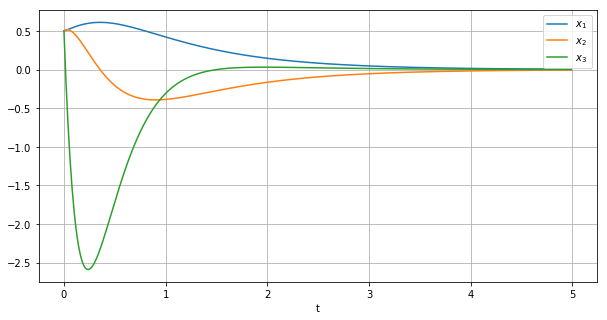

In [8]:
NumericalSolution(linear_system,systvars,lincontrol,[("t1",-31.6798),("t2",-29.1165),("t3", -4.91909)],[0.5,0.5,0.5],5,0.01)

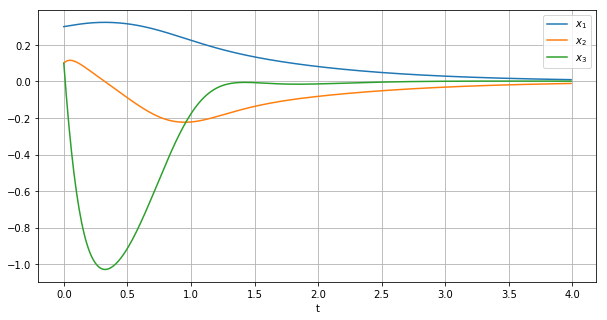

In [11]:
NumericalSolution(nonlinear_system,systvars,lincontrol,[("t1",-31.6798),("t2",-29.1165),("t3", -4.91909)],[0.3,0.1,0.1],4,0.01)

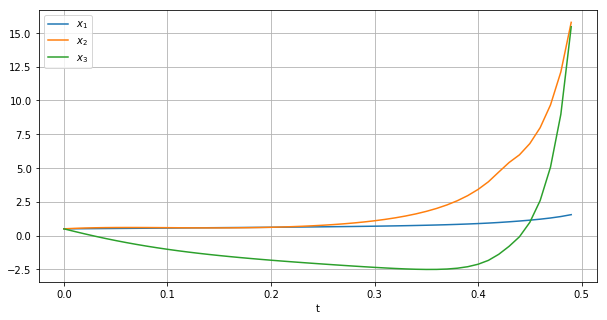

In [12]:
NumericalSolution(nonlinear_system,systvars,lincontrol,[("t1",-31.6798),("t2",-29.1165),("t3", -4.91909)],
                  [0.5,0.5,0.5],0.5,0.01)

<font size="3">
$$
\text{б) Перевести пару собственных чисел } \lambda_{1} \approx 0.919 \ \lambda_{2} \approx -1.138 \\
\text{в заданные точки } \mu_{1} = - 2.9 \ \mu_{2} = - 2.1   \text{ в левой полуплоскости комплексной плоскости.}\\
\mu_{1} = - 2.9 \\
\mu_{2} = -2.1 \\
\mu_{3} = -4.78128 \\
$$

In [13]:
Move(-2.9, -2.1, eig[2])

θ1* = -4.78128,  θ2* = -6.09, θ3* = -3.66802
θ1 = -38.8993,  θ2 = -29.9964, θ3 = -4.78128
Проверка: 
λ1= -2.1,  λ2 = -2.9, λ3 = -4.78128


<font size="3">
$
\begin{cases}
 \hat{\theta_{1}} = -4.78128  \\
 \hat{\theta_{2}} = -6.09  \\
 \hat{\theta_{3}} = -3.66802 \\
\end{cases} \\
\Theta = \hat{\Theta}S^{-1} = \begin{bmatrix}
 -4.78128\\
 -6.09  \\
-3.66802 
\end{bmatrix} 
\begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & -5 \\
1 & -5 & 24 
\end{bmatrix} 
= \begin{bmatrix}
 -38.8993 \\
 -29.9964\\
 -4.78128 
\end{bmatrix} \\
\text{Проверим полученное управление для линейной и нелинейной систем} 
$

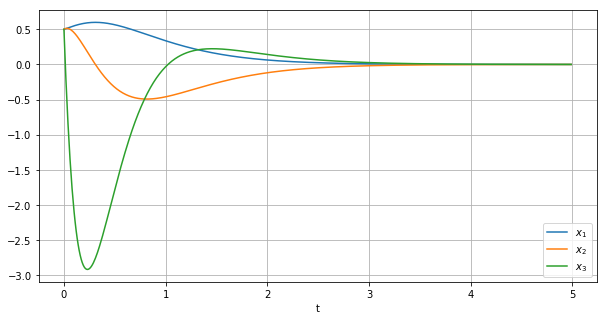

In [14]:
NumericalSolution(linear_system,systvars,lincontrol,[("t1",-38.8993),("t2",-29.9964),("t3", -4.78128)],[0.5,0.5,0.5],5,0.01)

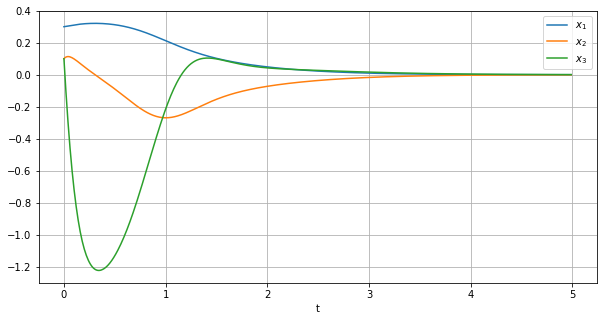

In [15]:
NumericalSolution(nonlinear_system,systvars,lincontrol,[("t1",-38.8993),("t2",-29.9964),("t3", -4.78128)],[0.3,0.1,0.1],5,0.01)

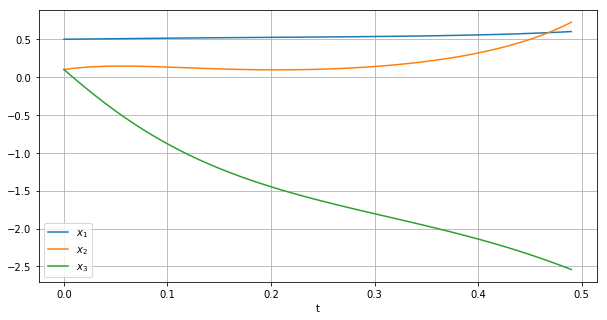

In [16]:
NumericalSolution(nonlinear_system,systvars,lincontrol,[("t1",-38.8993),("t2",-29.9964),("t3", -4.78128)],
                  [0.5,0.1,0.1],0.5,0.01)

<font size="3">
$$
\text{в) Перевести пару собственных чисел } \lambda_{1} \approx 0.919 \ \lambda_{2} \approx -1.138 \\
\text{в комплексно сопряжённые точки } \mu_{1} = -1 - 1.8i \ \mu_{2} = -1 + 1.8i    \\
\text{ в левой полуплоскости комплексной плоскости.}\\
\mu_{1} =  -1 - 1.8i \\
\mu_{2} = -1 + 1.8i \\
\mu_{3} = -4.78128 \\
$$

In [17]:
first = complex(-1, -1.8)
second = complex(-1, 1.8)
Move(first, second, eig[2])

θ1* = -1.78128+0j,  θ2* = -4.89615-0j, θ3* = -0.7919+0j
θ1 = -27.0539+0j,  θ2 = -13.8026+0j, θ3 = -1.78128+0j
Проверка: 
λ1= -1+1.8j,  λ2 = -1-1.8j, λ3 = -4.78128+0j


<font size="3">
$$
\begin{cases}
 \hat{\theta_{1}} = -1.78128  \\
 \hat{\theta_{2}} = -4.89615  \\
 \hat{\theta_{3}} = -0.7919 \\
\end{cases} \\
\Theta = \hat{\Theta}S^{-1} = \begin{bmatrix}
 -1.78128\\
 -4.89615  \\
-0.7919 
\end{bmatrix} 
\begin{bmatrix}
0 & 0 & 1 \\
0 & 1 & -5 \\
1 & -5 & 24 
\end{bmatrix} 
= \begin{bmatrix}
 -27.0539 \\
 -13.8026 \\
 -1.78128 
\end{bmatrix} \\
\text{Проверим полученное управление для линейной и нелинейной систем} 
$$

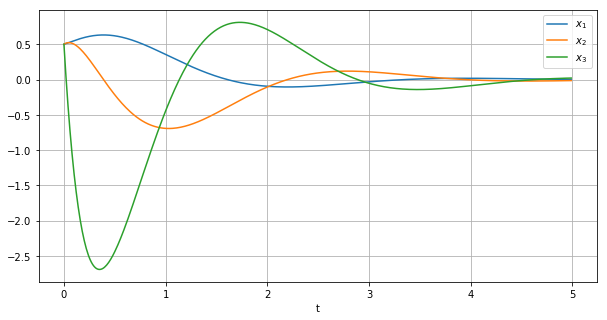

In [18]:
NumericalSolution(linear_system,systvars,lincontrol,[("t1",-27.0539),("t2",-13.8026),("t3", -1.78128)],[0.5,0.5,0.5],5,0.01)

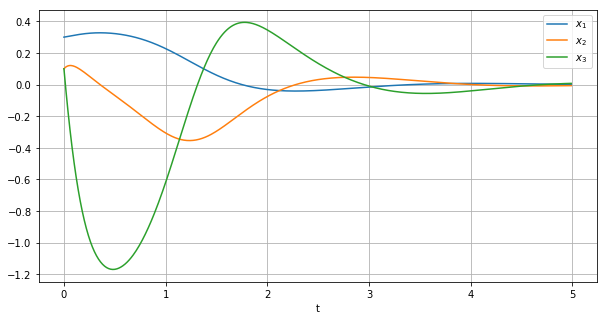

In [19]:
NumericalSolution(nonlinear_system,systvars,lincontrol,[("t1",-27.0539),("t2",-13.8026),("t3", -1.78128)],[0.3,0.1,0.1],5,0.01)

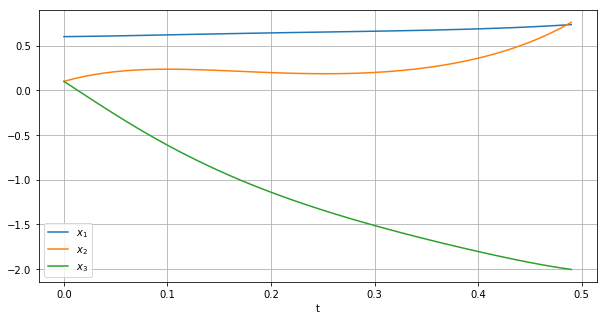

In [20]:
NumericalSolution(nonlinear_system,systvars,lincontrol,[("t1",-27.0539),("t2",-13.8026),("t3", -1.78128)],
                  [0.6,0.1,0.1],0.5,0.01)

<font size="3">
$$
\text{г) Перевести все собственные числа в заданные точки}\\
\mu_{1} = \mu_{2} =\mu_{2} = -1     \\
\text{ в левой полуплоскости комплексной плоскости.}\\
\mu_{1} = - 1 \\
\mu_{2} = -1 \\
\mu_{3} = -1 \\
$$

In [21]:
Move(-1, -1, -1)

θ1* = 2,  θ2* = -13, θ3* = 59
θ1 = -4,  θ2 = -3, θ3 = 2
Проверка: 
λ1= -0.999995+8.44448e-06j,  λ2 = -0.999995-8.44448e-06j, λ3 = -1.00001+0j


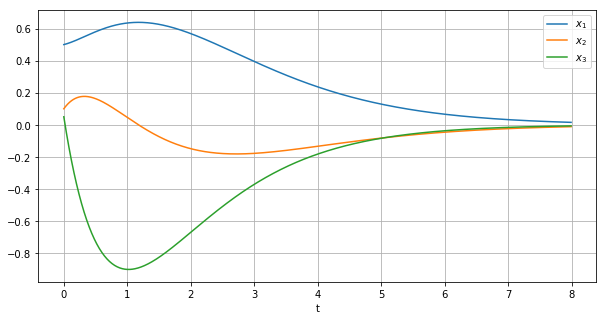

In [22]:
NumericalSolution(linear_system,systvars,lincontrol,[("t1",-4),("t2",-3),("t3", 2)],[0.5,0.1,0.05],8,0.01)

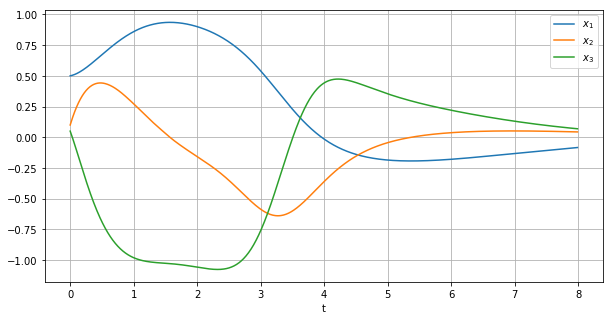

In [23]:
NumericalSolution(nonlinear_system,systvars,lincontrol,[("t1",-4),("t2",-3),("t3", 2)],[0.5,0.1,0.05],8,0.01)

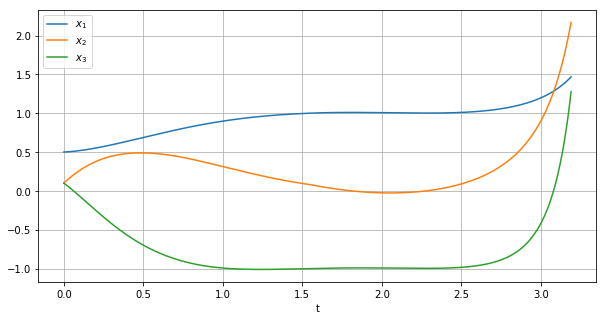

In [24]:
NumericalSolution(nonlinear_system,systvars,lincontrol,[("t1",-4),("t2",-3),("t3", 2)],[0.5,0.1,0.1],3.2,0.01)

<font size="3">
$$
\text{Использование регулятора} \  u = \theta_1 x_1 + \theta_3 x_3 \\
\text{Найдём $\hat\theta$ при условии  $\theta_2 = 0 $  :  $\hat\theta = \theta S = (x_3,-5x_3,x_1+24x_3)$ } \\
\text{Из второго уравнения системы для нахождения $\hat\theta$ имеем : $ 0 = (-\mu_1\mu_2 - \mu_1\mu_3 - \mu_2\mu_3) $}\\
\text{Но такого набора $\mu$ с отрицательными действительными частями не существует,}\\
\text{следовательно в таком виде управление нереализуемо.}
$$
</font>

### Вывод 
<font size="3">
$
~\\
\text{Во всех четырёх вариантах линейное управление по состоянию}\\ \text{работало для любых н.у. линеаризованной системы.} \\
\text{Однако для нелинейной системы добиться стабилизации можно только}\\ \text{с н.у. вблизи состояния равновесия, }
\text{иначе система идёт вразнос.}\\
\text{Из особенностей переходных процессов можно отметить: }\\
\text{В варианте в) с комплексно сопряжёнными корнями осцилляция сильнее всего,}\\
\text{В варианте г) с самостоятельно выбранными корнями имеет самое большое время установления}\\
\text{вследствие малости корней по модулю.}\\
\text{В варианте б) время установления меньше чем в варианте а),}\\ \text{однако амплитуда первых колебаний выше.}\\
\text{Также для всех вариантов время установления для нелинейной системы больше.}\\
$
</font>

### Задание 2

<font size="3">
$$
X = [x_{1}, x_{2}, x_{3}] \\
\dot{X} = AX+BU\\
\text{Линеаризованная система в окрестности состояния равновесия (0, 0, 0)} \\
\begin{bmatrix}
\dot{x_{1}}  \\
\dot{x_{2}}  \\
\dot{x_{3}} 
\end{bmatrix} =
\begin{bmatrix}
0 & 1 & 0 \\
1 & 0 &  1 \\
0 & -1 &  -5 
\end{bmatrix}
\begin{bmatrix}
x_{1} \\
x_{2}  \\
x_{3}
\end{bmatrix} +
\begin{bmatrix}
0 \\
0 \\
1  
\end{bmatrix}
U \\
\text{Перейдем к дискретной системе}\\
\xi_{k+1} = e^{A(t_{k+1} - t_k)}\xi_{k} + \int_{t_k}^{t_{k+1}} e^{A(t_{k+1}-s)}BU(s) ds \\
U(s) = u_k \\
t_{k+1} - t_k = h \\
t = t_{k+1} - s \\
\xi_{k+1} = e^{Ah}\xi_{k} + \int_{0}^{h} e^{At}Bu_kdt \\
\text{Найдем интеграл}\\
\xi_{k+1} = e^{Ah}\xi_{k} + A^{-1}(e^{Ah}-E)Bu_kdt \\
\text{Найдём  $ e^{Ah} $:}\\
\text{Собственные числа матрицы $ Ah $ : $ \lambda_1= -4.781h , \lambda_2= -1.138h,\lambda_3=0.919h $} \\
\text{ $ e^{Ah} $ для $ h = 0.1 $:} \\
e^{Ah} \approx
\begin{bmatrix}
1.005 & 0.10001 & 0.00426 \\
0.10001 & 1.00074 & 0.07871 \\
-0.00426 & -0.07871 &  0.60292 \\
\end{bmatrix}\\
\text{ Тогда новая система $ \xi_{k+1} =\tilde{A}\xi_{k} + \tilde{B}u_k  $ :} \\
\xi_{k+1} = 
\begin{bmatrix}
1.005 & 0.10001 & 0.00426 \\
0.10001 & 1.00074 & 0.07871 \\
-0.00426 & -0.07871 &  0.60292 
\end{bmatrix} \xi_{k} + 
\begin{bmatrix}
0.00015 \\
0.00426  \\
0.07856  
\end{bmatrix}u_k \\
\text{Будем использовать закон управления в виде линейной обратной связи по состоянию}\\
u_k = \theta_1\xi_{1,k}+\theta_2\xi_{2,k}+\theta_3\xi_{3,k} \\
\text{Найдем собственные числа новой матрицы и её левые собственные векторы} \\
\text{Собственные числа матрицы $ \tilde{A} $ : $ \lambda_1= 0.61994 , \lambda_2= 0.89245,\lambda_3=1.09626 $} \\
\text{Собственные векторы: 
$ v_1 = \begin{bmatrix}
-0.04464 \\
0.21345  \\
0.97593  \\
\end{bmatrix}  ,
v_2 = \begin{bmatrix}
0.64801 \\
-0.73731  \\
-0.19090  \\
\end{bmatrix} ,
v_3 = \begin{bmatrix}
0.7315 \\
0.67231  \\
0.11358  \\
\end{bmatrix} \\$} 
$$

## А)
<font size="3">
$$
\text{ Подвинем неустойчивое собственное число } \lambda_3 =  1.09626 \text{ в } e^{-4} \\
\text{Проверим условие на управляемость моды} \\
v_3^T\tilde{B} = 0.01189674 \neq 0 \\
\text{Матрица преобразования к блочно-диагональному виду:} \\
P^{-1} =
\begin{bmatrix}
0.7315 & 0.67231 & 0.11358\\
0 & 1 & 0 \\
0 & 0 &  1 \\
\end{bmatrix} , 
P =
\begin{bmatrix}
1.36705 & -0.91909 & -0.15527\\
0 & 1 & 0 \\
0 & 0 &  1 \\
\end{bmatrix}\\
\widehat{A} = P^{-1}\tilde{A}P =
\begin{bmatrix}
1.09626 & 0 & 0\\
0.13673 & 0.90881 & 0.06318 \\
-0.00583 & -0.07479 & 0.60358 \\
\end{bmatrix}\\
\widehat{B} = P^{-1}\tilde{B} =
\begin{bmatrix}
0.01189\\
0.00426\\
0.07856\\
\end{bmatrix}\\
\widehat{\theta} = 
\begin{bmatrix}
\widehat{\theta}_1 & 0 & 0\\
\end{bmatrix} ,
A_c = \widehat{A} + \widehat{B} \widehat{\theta} = \begin{bmatrix}
1.09626 + 0.01189\theta_1  & 0 & 0\\
0.13673 + 0.00426\theta_1 & 0.90881 & 0.06318 \\
-0.00583 + 0.07856\theta_1 & -0.07479 & 0.60358 \\
\end{bmatrix}\\
1.09626 + 0.01189\theta_1 = e^{-4} 
\text{,  Отсюда:  }
\widehat{\theta_1} \approx -90.60882821 \\
\theta = \widehat{\theta}P^{-1} = 
\begin{bmatrix}
-66.28038 & -60.91757 & -10.29171\\
\end{bmatrix}\\
\text{Проверим полученное управление:}\\
\text{Линейная дискретная система, н.у. (1,2,3)}
$$
    
![alt text](https://sun9-56.userapi.com/c858120/v858120561/12c306/xWARhcbzEh0.jpg)
    
$$ \text{Линейная непрерывная система, н.у. (1,2,3)} $$
    
![alt text](https://sun9-59.userapi.com/c858120/v858120561/12c30d/rj_WebEUYqA.jpg)
    
$$ \text{Нелинейная непрерывная система, н.у. (0.5,0.5,0.5)} $$
    
![alt text](https://sun9-19.userapi.com/c858120/v858120561/12c331/XGD82Avq_9E.jpg)
 
$$ \text{Нелинейная непрерывная система, н.у. (0.3,0.1,0.1)} $$
    
![alt text](https://sun9-19.userapi.com/c858120/v858120561/12c343/ri_iW_YbdLs.jpg)
    
$$ 
\text{Для перевода моды в заданную точку $ m $ имеем выражение для $ \widehat{\theta_1} = 84.1043 m - 92.2002 $}\\
\text{Следовательно } 
\theta = 
\begin{bmatrix}
61.5223m - 67.4444 & 56.5442 m - 61.9871 & 9.55257 m - 10.4721 \\
\end{bmatrix}\\
\text{Отсюда имеем что при $ \theta_2 = 0 $ ,    $m = 1.09626 > 1$} \\
\text{При $ \theta_2 = 0 $ передвинуть моду в устойчивую область нельзя}
$$

## Б)
<font size="3">
$$
\text{ Подвинем собственные числа:} \\
\lambda_3 =  1.09626 \text{ в } e^{-2.9} \;
\lambda_2 =  0.89245 \text{ в } e^{-2.1} \\
\text{Проверим условия на управляемость мод:} \\
v_3^T\tilde{B} = 0.01189674 \neq 0 \\
v_2^T\tilde{B} = -0.01804453 \neq 0 \\
\text{Матрица преобразования к блочно-диагональному виду:} \\
P^{-1} =
\begin{bmatrix}
0.7315 & 0.67231 & 0.11358\\
0.64801 & -0.73731 & -0.1909\\
0 & 0 &  1 \\
\end{bmatrix} , 
P =
\begin{bmatrix}
0.7562 &  0.68954 & 0.04574\\
0.66462 & -0.75024 & -0.21871 \\
0 & 0 &  1 \\
\end{bmatrix}\\
\widehat{A} = P^{-1}\tilde{A}P =
\begin{bmatrix}
1.09626 & 0 & 0\\
0 & 0.89245 & 0\\
-0.05554 & 0.05611 & 0.61994\\
\end{bmatrix}\\
\widehat{B} = P^{-1}\tilde{B} =
\begin{bmatrix}
0.0119\\
-0.01804\\
0.07856\\
\end{bmatrix}\\
\widehat{\theta} = 
\begin{bmatrix}
\widehat{\theta}_1 & \widehat{\theta}_2 & 0\\
\end{bmatrix} ,
A_c = \widehat{A} + \widehat{B} \widehat{\theta} = \begin{bmatrix}
0.0119\theta1 + 1.09626 & 0.0119\theta_2 & 0\\
-0.01804\theta_1 & -0.01804\theta_2 + 0.89245 & 0 \\
0.07856\theta_1 - 0.05554 & 0.07856\theta_2 + 0.05611 & 0.61994 \\
\end{bmatrix}\\
\text{Для получения системы уравнений относительно $\theta_1$ и $\theta_2$ }\\
\text{подставим желаемые моды в характеристическое уравнение матрицы $ A_c $:} \\
\begin{cases}
 -0.00563\theta_1 + 0.01061\theta_2 - 0.49258 = 0 \\
 -0.00456\theta_1 + 0.00874\theta_2 - 0.37302 = 0  \\
\end{cases} \\
\text{Отсюда:  }
\widehat{\theta_1} \approx -418.186 \;
\widehat{\theta_2} \approx -175.333 \\
\theta = \widehat{\theta}P^{-1} = 
\begin{bmatrix}
-419.52151379 & -151.87673556 & -14.02720934\\
\end{bmatrix}\\
\text{Проверим полученное управление:}\\
\text{Линейная дискретная система, н.у. (1,2,3)}
$$
    
![alt text](https://sun9-9.userapi.com/c858120/v858120617/12ef4f/yuwMaA3rRq4.jpg)
    
$$ \text{Линейная непрерывная система, н.у. (1,2,3)} $$
    
![alt text](https://sun9-15.userapi.com/c858120/v858120617/12ef64/yfOyJYXMgy8.jpg)
    
$$ \text{Нелинейная непрерывная система, н.у. (0.5,0.5,0.5)} $$
    
![alt text](https://sun9-69.userapi.com/c858120/v858120617/12ef6b/agrU1pxduB4.jpg)
 
$$ \text{Нелинейная непрерывная система, н.у. (0.1,0.01,0.2)} $$
    
![alt text](https://sun9-72.userapi.com/c858120/v858120617/12ef72/5Yd5iaGPdkw.jpg)

## В)
<font size="3">
$$
\text{ Подвинем собственные числа:} \\
\lambda_3 =  1.09626 \text{ в } -0.08358 - 0.35826i \;\;
\lambda_2 =  0.89245 \text{ в } -0.08358 + 0.35826i \\
\text{Проверим условия на управляемость мод:} \\
v_3^T\tilde{B} = 0.01189674 \neq 0 \\
v_2^T\tilde{B} = -0.01804453 \neq 0 \\
\text{Матрица преобразования к блочно-диагональному виду:} \\
P^{-1} =
\begin{bmatrix}
0.7315 & 0.67231 & 0.11358\\
0.64801 & -0.73731 & -0.1909\\
0 & 0 &  1 \\
\end{bmatrix} , 
P =
\begin{bmatrix}
0.7562 &  0.68954 & 0.04574\\
0.66462 & -0.75024 & -0.21871 \\
0 & 0 &  1 \\
\end{bmatrix}\\
\widehat{A} = P^{-1}\tilde{A}P =
\begin{bmatrix}
1.09626 & 0 & 0\\
0 & 0.89245 & 0\\
-0.05554 & 0.05611 & 0.61994\\
\end{bmatrix}\\
\widehat{B} = P^{-1}\tilde{B} =
\begin{bmatrix}
0.0119\\
-0.01804\\
0.07856\\
\end{bmatrix}\\
\widehat{\theta} = 
\begin{bmatrix}
\widehat{\theta}_1 & \widehat{\theta}_2 & 0\\
\end{bmatrix} ,
A_c = \widehat{A} + \widehat{B} \widehat{\theta} = \begin{bmatrix}
0.0119\theta1 + 1.09626 & 0.0119\theta_2 & 0\\
-0.01804\theta_1 & -0.01804\theta_2 + 0.89245 & 0 \\
0.07856\theta_1 - 0.05554 & 0.07856\theta_2 + 0.05611 & 0.61994 \\
\end{bmatrix}\\
\text{Для получения системы уравнений относительно $\theta_1$ и $\theta_2$ }\\
\text{подставим одну из желаемых мод в характеристическое уравнение матрицы $ A_c $:} \\
-0.006642\theta_1 + 0.01266\theta_2 - 0.44316 + (0.00716\theta_1 - 0.01217\theta_2 + 0.909957)i = 0 \\
\text{Откуда, разделяя вещественную и мнимую часть получаем пару уравнений:} \\
\begin{cases}
 -0.006642\theta_1 + 0.01266\theta_2 - 0.44316 = 0 \\
  0.00716\theta_1 - 0.01217\theta_2 + 0.909957 = 0  \\
\end{cases} \\
\text{Отсюда:  }
\widehat{\theta_1} \approx -627.046 \;
\widehat{\theta_2} \approx -293.935 \\
\theta = \widehat{\theta}P^{-1} = 
\begin{bmatrix}
-649.1584833 & -204.84926907 & -15.10859164\\
\end{bmatrix}\\
\text{Проверим полученное управление:}\\
\text{Линейная дискретная система, н.у. (1,2,3)}
$$
    
![alt text](https://sun9-43.userapi.com/c858120/v858120859/12ecc3/9fniiyOm3xs.jpg)
    
$$ \text{Линейная непрерывная система, н.у. (1,2,3)} $$
    
![alt text](https://sun9-64.userapi.com/c858120/v858120859/12ecca/qweAW12UxBc.jpg)
    
$$ \text{Нелинейная непрерывная система, н.у. (0.5,0.5,0.5)} $$
    
![alt text](https://sun9-48.userapi.com/c858120/v858120859/12ecd1/6MLpfuH2qQo.jpg)
 
$$ \text{Нелинейная непрерывная система, н.у. (0.0296,0.1,0.2)} $$
    
![alt text](https://sun9-53.userapi.com/c858120/v858120859/12ece2/gD5OfXDQfxs.jpg)

<font size="3">
$$
\text{Совершенно так же как и для задачи 1, линейный регулятор, построенный с помощью перехода}\\
\text{к дискретной системе, работает с любыми н.у. только для линейных систем,}\\
\text{для нелинейных лишь в малой окрестности состояния равновесия.}
$$

In [90]:
from pylab import *
from scipy.linalg import *
import numpy as np
from sympy.parsing.sympy_parser import parse_expr
from sympy.utilities.lambdify import lambdify
from sympy import Matrix, solve
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def DiscreteSystem(A,B,u,x0,h,steps):
    
    # Численное интегрирование 
    time_span = np.arange(0, h*steps, h)
    xk = x0
    data = [[] for i in range(3)]
    for i in range(steps):
        data[0].append(xk[0])
        data[1].append(xk[1])
        data[2].append(xk[2])
        xk = A*xk + B*(u*xk)
    fig = plt.figure(figsize=(10, 5))
    for i in range (3):
        plt.plot(time_span,data[i])
    plt.legend([r'$x_1$', r'$x_2$',r'$x_3$',], fontsize=10)
    plt.xlabel('t', fontsize=10)
    plt.grid()
    plt.show()

In [184]:
h = 0.1
A = np.matrix([[0, 1, 0],
     [1, 0, 1],
     [0, -1, -5]])
print(eig(A))
B = np.matrix([[0],
     [0],
     [1]])
A_ = np.asmatrix(expm(h*A))

print(A_)

(array([ 0.919089 +0.j, -1.1378052+0.j, -4.7812838+0.j]), array([[ 0.73150031, -0.64801449,  0.04464331],
       [ 0.67231389,  0.73731426, -0.21345234],
       [-0.11358401, -0.19090551,  0.97593292]]))
[[ 1.00500038  0.10001891  0.00426158]
 [ 0.10001891  1.0007388   0.07871101]
 [-0.00426158 -0.07871101  0.60292217]]


In [185]:
E = np.matrix(eye(3))
B_ = inv(A)*(A_ - E)*B
print(B_)

[[0.00014776]
 [0.00426158]
 [0.07856325]]


In [188]:
lymbda = eig(A_,left=True,right=False)
print(lymbda)

(array([1.09626495+0.j, 0.89245381+0.j, 0.6199426 +0.j]), array([[ 0.73150031,  0.64801449, -0.04464331],
       [ 0.67231389, -0.73731426,  0.21345234],
       [ 0.11358401, -0.19090551,  0.97593292]]))


In [189]:
v_3 = np.matrix([lymbda[1][0][0], lymbda[1][1][0], lymbda[1][2][0]])
print(v_3)
print(v_3*B_, "!= 0")

[[0.73150031 0.67231389 0.11358401]]
[[0.01189674]] != 0


In [190]:
print("Двигаем в ", math.e**(-4))

Двигаем в  0.018315638888734186


In [231]:
invP =np.matrix([[lymbda[1][0][0], lymbda[1][1][0], lymbda[1][2][0]], [0, 1, 0], [0, 0, 1]])
print("invP: ")
print(invP)
P = np.linalg.inv(invP)
print("P: ")
print(P)

A_new =  invP*A_*P
print(B_)

B_new = invP*B_
print("A_new = ")
print(np.around(A_new,decimals =5))
print("B_new = ")
print(B_new)

invP: 
[[0.73150031 0.67231389 0.11358401]
 [0.         1.         0.        ]
 [0.         0.         1.        ]]
P: 
[[ 1.36705342 -0.919089   -0.15527541]
 [ 0.          1.          0.        ]
 [ 0.          0.          1.        ]]
[[0.00014776]
 [0.00426158]
 [0.07856325]]
A_new = 
[[ 1.09626  0.       0.     ]
 [ 0.13673  0.90881  0.06318]
 [-0.00583 -0.07479  0.60358]]
B_new = 
[[0.01189674]
 [0.00426158]
 [0.07856325]]


In [210]:
Theta_ = (math.e**(-4) - lymbda[0][0])/(B_new[0][0])
Theta_ =np.matrix([complex(Theta_[0][0]), 0 , 0])
print(Theta_)
Theta = Theta_*invP
Theta = [[0,0,0]]
print(Theta)

[[-90.60882821+0.j   0.        +0.j   0.        +0.j]]
[[0, 0, 0]]


In [128]:
print("Двигаем в ", math.e**(-4))
print("Двигаем в ", math.e**(-2.1))

Двигаем в  0.018315638888734186
Двигаем в  0.12245642825298192


In [212]:
v_2 = np.matrix([lymbda[1][0][1], lymbda[1][1][1], lymbda[1][2][1]])
print(v_2)
print(v_2*B_, "!= 0")

[[ 0.64801449 -0.73731426 -0.19090551]]
[[-0.01804453]] != 0


In [232]:
invP =np.matrix([[lymbda[1][0][0], lymbda[1][1][0], lymbda[1][2][0]],
                 [lymbda[1][0][1], lymbda[1][1][1], lymbda[1][2][1]],
                  [0, 0, 1]])
print("invP: ")
print(invP)
P = np.linalg.inv(invP)
print("P: ")
print(P)

A_new =  invP*A_*P
print(B_)

B_new = invP*B_

A_new = np.around(A_new,decimals = 5)
B_new = np.around(B_new,decimals = 5)

print("A_new = ")
print(A_new)
print("B_new = ")
print(B_new)

theta = np.matrix([parse_expr("t1"),parse_expr("t2"),0])

test = Matrix(A_new + B_new*theta)
print(test)
print(test.charpoly(parse_expr("x")).subs([(parse_expr("x"),0.05502322005)]))

invP: 
[[ 0.73150031  0.67231389  0.11358401]
 [ 0.64801449 -0.73731426 -0.19090551]
 [ 0.          0.          1.        ]]
P: 
[[ 0.75620831  0.68954228  0.04574424]
 [ 0.66462019 -0.75024538 -0.2187162 ]
 [ 0.          0.          1.        ]]
[[0.00014776]
 [0.00426158]
 [0.07856325]]
A_new = 
[[ 1.09626 -0.       0.     ]
 [-0.       0.89245  0.     ]
 [-0.05554  0.05611  0.61994]]
B_new = 
[[ 0.0119 ]
 [-0.01804]
 [ 0.07856]]
Matrix([[0.0119*t1 + 1.09626, 0.0119*t2, 0.0], [-0.01804*t1, -0.01804*t2 + 0.89245, 0.0], [0.07856*t1 - 0.05554, 0.07856*t2 + 0.05611, 0.619940000000000]])
-0.00562960963568169*t1 + 0.0106113468052633*t2 - 0.492584589027958


In [233]:
Theta =np.matrix([-418.069, -175.377 , 0])
#print(invP)
Theta = Theta*invP
print(Theta)
#print(A+B*Theta)
print("Проверка: ")
print(eig(A_+B_*Theta))
#u = np.matrix([-339.52832239,-920.30350808,-185.75382402]) 
#print(u)
#DiscreteSystem(A_,B_, u,[[1],[1],[0]],h,400)

[[-419.46444089 -151.76563301  -14.00552017]]
Проверка: 
(array([0.6199426 +0.j        , 0.08982887+0.02780319j,
       0.08982887-0.02780319j]), array([[ 0.04464331+0.j        , -0.00248564-0.00038834j,
        -0.00248564+0.00038834j],
       [-0.21345234+0.j        ,  0.05567723+0.00337938j,
         0.05567723-0.00337938j],
       [ 0.97593292+0.j        , -0.99843993+0.j        ,
        -0.99843993-0.j        ]]))


### Распределение работы ###
<font size="3">
$
~\\
\text{Дмитрий был основоположником работы: описал большую часть теории}\\
\text{и написал неповторимую функцию для движения мод.}\\
~\\
\text{Иван добавлял теории и обновлял текстовое оформление в современный стиль,}\\ \text{ и был первым человеком,}\\
\text{который сказал, что нужно переходить от } \hat\theta \text{ к } \theta. \\
~\\
\text{Вова был и есть главный программист в команде, он занимался отрисовкой графиков}\\
\text{и отслеживал работу Дмитрия и Вани}
$
</font>